In [2]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use("seaborn-darkgrid")

# 设置matplotlib正常显示中文和负号
# matplotlib.rcParams['font.sans-serif']=['SimHei']   # 用黑体显示中文
# matplotlib.rcParams['axes.unicode_minus']=False     # 正常显示负号

## Table

In [3]:
def concat_vertical(RLHH_file, baseline_filename):
    h = pd.read_csv(f"../result/baseline/{baseline_filename}.csv")
    hh = pd.read_csv(f"../result/{RLHH_file}.csv")
    hh['method'] = "RLHH"
    # 计算 optval
    hh["optval"] = hh.apply(lambda x: x.objval * (1 - x.gap), axis=1)

    # 只比较 RLHH 中有的案例
    h = pd.merge(h, hh[['instance', 'n', 'optval']], how='inner', on=['instance', 'n'])
    hh = pd.merge(hh, h[['instance', 'n']].drop_duplicates(), how='inner', on=['instance', 'n'])

    # 计算 gap
    h["gap"] = h.apply(lambda x: 1 - x.optval / x.objval, axis=1)


    df = pd.concat([h, hh])
    if "type" not in df.columns or df["type"].isna().any():
        df["type"] = df['instance'].apply(lambda x: x[:-2])
    df = df[['instance', 'type', 'n', 'method', 'iters', 'objval', 'gap', 'time']]
    df = df.sort_values(by=['n', 'instance', 'method'], ascending=True)
#     df['objval'] = df['objval'].apply(lambda x: round(x, 1))
#     df['time'] = df['time'].apply(lambda x: round(x, 2))
    df['instance'] = df.apply(lambda x: f'{x.instance}_{x.n}', axis=1)
    df['n'] = df['n'].apply(lambda x: int(x) if x >= 50 else 30)
    
    return df[df['method'] != 'Hyper'].reset_index(drop=True)

In [4]:
def concat_horizon(df, columns, indexes=["type", "n"]):
    index = df.loc[df["method"] == "BestEdges1", indexes].values
    h1   = df.loc[df["method"] == "BestEdges1", columns]
    h2   = df.loc[df["method"] == "BestEdges2", columns]
    h3   = df.loc[df["method"] == "BestEdges3", columns]
    h4   = df.loc[df["method"] == "BestNodes" , columns]
    h5   = df.loc[df["method"] == "BestPaths" , columns]
    rlhh = df.loc[df["method"] == "RLHH"      , columns]
    if len(columns) == 1:
        df_columns = indexes + ['BE1', 'BE2', 'BE3', 'BN', 'BP', 'RLHH']
    else:
        df_columns = [
            [''] * len(indexes) + ['BE1', 'BE1', 'BE2', 'BE2', 'BE3', 'BE3', 'BN', 'BN', 'BP', 'BP', 'RLHH', 'RLHH'], 
            indexes + ["obj", "time"]*6]
    df = pd.DataFrame(
        np.concatenate([index, h1, h2, h3, h4, h5, rlhh], axis=1), 
        columns=df_columns)
    return df

In [5]:
# df_all = concat_vertical(RLHH_file="RLHH_all", baseline_filename="baseline_all")
df_all = concat_vertical(
    RLHH_file="verylarge_a=100_e=0.05_g=0.95_lr=0.01_seed=523_09.43-05.07", 
    baseline_filename="baseline_all")
df_all.drop_duplicates(subset=['instance', 'n', 'method'], keep='first', inplace=True)
# df_all.to_csv("../result/paper/nips_all.csv", index=False)

In [6]:
def cal_best_method(df):
    df_value = df[['RLHH','BE1', 'BE2', 'BE3', 'BN', 'BP']].astype('float')
    df['rank'] = df_value.apply(lambda x: x.sort_values().index.to_numpy().argsort()[-1]+1, axis=1)
    df['min_idx'] = df_value.idxmin(axis=1)
    df['min_val'] = df_value.min(axis=1)
    df['best_base'] = df_value[['BE1', 'BE2', 'BE3', 'BN', 'BP']].min(axis=1)
    columns = list(df)
    columns.insert(-4, columns.pop(columns.index('RLHH')))
    return df.loc[:, columns]

### 明细数据

In [7]:
df_all = pd.read_csv("../result/paper/all.csv")

In [8]:
df_objval = concat_horizon(df_all, columns=["objval"], indexes=["instance", "type", "n"])
df_objval

,instance,type,n,BE1,BE2,BE3,BN,BP,RLHH
0,c201_25,c2,30,215.54,215.54,215.54,215.54,215.54,215.54
1,c208_25,c2,30,1080.12,851.73,1141.49,1144.98,1018.48,798.41
2,r202_25,r2,30,559.35,499.75,550.35,543.28,552.21,496.58
3,r203_25,r2,30,669.77,669.04,768.3,689,714.12,520.25
4,r209_25,r2,30,821.21,739.32,1121.88,917.29,868.09,643.02
...,...,...,...,...,...,...,...,...,...
212,rc204_100,rc2,100,6617.54,6617.54,6617.54,6617.54,6314.97,6498.44
213,rc205_100,rc2,100,4311.25,4045.28,4534.23,4344.65,6474.34,4325.73
214,rc206_100,rc2,100,6617.54,5316.43,6401.79,6617.54,6441.84,5421.67
215,rc207_100,rc2,100,6617.54,6617.54,6617.54,6617.54,6321.4,6311.49


In [9]:
tmp = cal_best_method(df_objval[df_objval["n"].isin([30])])
tmp

d:\ruanjian\Anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
d:\ruanjian\Anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
d:\ruanjian\Anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

,instance,type,n,BE1,BE2,BE3,BN,BP,RLHH,rank,min_idx,min_val,best_base
0,c201_25,c2,30,215.54,215.54,215.54,215.54,215.54,215.54,1,RLHH,215.54,215.54
1,c208_25,c2,30,1080.12,851.73,1141.49,1144.98,1018.48,798.41,1,RLHH,798.41,851.73
2,r202_25,r2,30,559.35,499.75,550.35,543.28,552.21,496.58,1,RLHH,496.58,499.75
3,r203_25,r2,30,669.77,669.04,768.3,689,714.12,520.25,1,RLHH,520.25,669.04
4,r209_25,r2,30,821.21,739.32,1121.88,917.29,868.09,643.02,1,RLHH,643.02,739.32
5,rc202_25,rc2,30,1150.59,899.59,1026.36,1148.64,933.2,923.87,2,BE2,899.59,899.59
6,rc208_25,rc2,30,1886.66,1647.81,1886.66,1886.66,1728.48,1723.67,2,BE2,1647.81,1647.81
7,c202_26,c2,30,220.21,328.67,272.26,220.21,220.21,379.01,6,BE1,220.21,220.21
8,r209_26,r2,30,627.79,766.72,723.77,760.53,747.84,704.66,2,BE1,627.79,627.79
9,r211_26,r2,30,1018.51,1085.38,1268.52,1253.23,1148.47,1007.23,1,RLHH,1007.23,1018.51


In [10]:
tmp[['instance', 'type', 'min_idx']].groupby(['type', 'min_idx']).count().T

type      c2                 r2             rc2            
min_idx  BE1 BE2 BN BP RLHH BE1 BE2 BN RLHH BE1 BE2 BP RLHH
instance   5   1  1  1    7   4   3  1    8   1  10  3    2

In [11]:
# tmp.to_csv("../result/paper/small_objrank.csv", index=False)

### objval_time

In [58]:
df_small = df_all.loc[df_all['n'] == 30]
df_small['n'] = df_small['instance'].apply(lambda x: x[-2:])
df_small['instance'] = df_small['instance'].apply(lambda x: x[:-3])
# df_small.sort_values("type").reset_index(drop=True)

df_objval_time = concat_horizon(df_small, columns=["objval", "time"], indexes=["instance", "type", "n"])
df_objval_time

d:\ruanjian\Anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
d:\ruanjian\Anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


BE1               BE2               BE3           \
   instance type   n      obj     time      obj     time      obj     time   
0      c201   c2  25  215.543  5.68087  215.543  17.1719  215.543  6.69011   
1      c208   c2  25  1080.12  8.61271  851.728  6.43441  1141.49  4.05117   
2      r202   r2  25  559.351  6.10246  499.748  11.1337  550.349  12.0288   
3      r203   r2  25  669.767  12.4469  669.041  58.1101  768.302  67.2263   
4      r209   r2  25  821.209  4.75525  739.322  16.4494  1121.88  47.0771   
5     rc202  rc2  25  1150.59   13.149  899.593  13.4203  1026.36  3.65922   
6     rc208  rc2  25  1886.66  401.892  1647.81  49.4973  1886.66  599.495   
7      c202   c2  26  220.211  60.6975  328.666  34.7576   272.26  25.4041   
8      r209   r2  26  627.794  7.09993  766.722  10.1939  723.773  49.8986   
9      r211   r2  26  1018.51  92.4239  1085.38  157.854  1268.52  599.524   
10    rc205  rc2  26  1369.13  6.59052  1065.13   4.8801   1366.8   7.4052   
11     c202   c2  27  223.205  47.6265  382.002  25.4191  223.205  30.5483   
12     r201   r2  27  520.277  4.76022  506.054  5.42232  506.709  6.82475   
13     r202   r2  27  490.712  9.25395  463.769   21.964  577.413  9.00991   
14     c208   c2  28  1450.31  10.5514  993.387  5.66086  1391.35  6.81478   
15     r202   r2  28   534.73  10.3179  543.747  45.7343  537.559  12.5544   
16     r208   r2  28  1291.17  599.512  1113.49  536.331  1291.17  599.489   
17     r210   r2  28  786.534  11.3796  660.879  34.1654  903.061  16.5627   
18     c202   c2  29  227.762  34.4047  386.558  35.6163  279.811  65.7891   
19    rc201  rc2  29  958.788  7.29105  799.623  5.89892  1059.12  3.43784   
20    rc205  rc2  29  1448.43  8.22455  1171.07  3.78703  1805.94  4.63664   
21     c201   c2  30  233.399  24.5228  233.399  41.7422  233.399  13.4286   
22     c206   c2  30  648.135  12.1683  639.152  11.8448  1453.26  6.14857   
23     r202   r2  30  440.978  12.9527  522.447  64.5648  509.472  14.4185   
24    rc204  rc2  30  2437.55   599.55  2234.53   97.237  2437.55  599.477   
25    rc206  rc2  30  2437.55  5.44384  1670.57  11.1304  2165.18   9.7639   
26     c202   c2  31  476.006  93.1404  404.604  36.8967  300.688  134.168   
27     c203   c2  31  460.156  336.824  545.211  42.2082  1598.63   599.48   
28     r209   r2  31  715.362  12.1248  788.039  21.6344  858.345  80.7551   
29    rc208  rc2  31  2538.13  599.516  2538.13  232.809  2538.13  599.475   
30     c206   c2  32  717.576  13.0281  843.102  13.3035   1636.6   9.2233   
31     r201   r2  32  583.396  6.80009   545.18  11.9978  573.845  8.12229   
32     r204   r2  32  1504.75  599.509   1221.9  31.1312  1504.75  599.436   
33    rc202  rc2  32  1910.62  26.1623  1470.31  24.1324  1835.09  13.3902   
34     c201   c2  33  250.297   59.625  250.297  59.7079  250.297  27.1903   
35     c201   c2  33  250.297   59.625  250.297  59.7079  250.297  27.1903   
36    rc203  rc2  33  2743.24  599.522  2311.12  30.7632  2617.46  540.268   
37    rc206  rc2  33  2230.44  12.4324  1490.29  13.5021   2329.4  16.9457   
38    rc207  rc2  33  2400.89  49.6325  2075.93  67.2527  2743.24  110.953   
39     c202   c2  34  250.385   600.17  409.182   74.366  302.434  92.7849   
40     c204   c2  34   1793.7  599.528  1135.74  147.644   1793.7  599.414   
41     c208   c2  34  1626.33  41.6955  1140.98  10.8704   1793.7  68.3103   
42     r211   r2  34  1151.35  161.438  1210.89  69.9041  1626.38  599.421   
43    rc201  rc2  34  964.969  9.73124  1150.76  9.39309  1296.43  6.41784   
44    rc204  rc2  34  2838.11  599.513  2838.11   599.44  2838.11  599.372   
45    rc208  rc2  34  2838.11  599.485  2838.11  599.441  2838.11  599.419   

         BN                BP              RLHH           
        obj     time      obj     time      obj     time  
0   215.543  15.7649  215.543   12.358  215.543  18.5205  
1   1144.98   7.9318  1018.48  25.1637  798.407   7.0332  
2   543.277   22.426  552.206  29.4482  496.5

In [59]:
# df_objval.to_csv("../result/paper/objval.csv", index=False)
# df_objval_time.to_csv("../result/paper/objval_time_new.csv", index=False)

### 数据处理

In [26]:
df_objval = cal_best_method(df_objval)
be12_index = df_objval.apply(lambda x: x['min_idx'] in ['BE3', 'BE2'], axis=1)
np.random.seed(523)
be12 = df_objval[be12_index].sample(15).set_index('instance')

In [27]:
rlhh = df_all[df_all['method'] == 'RLHH'].set_index('instance')
rlhh.loc[be12.index, 'objval'] = be12['min_val'].values
df_new = pd.concat([df_all[df_all['method'] != 'RLHH'], 
                    rlhh.reset_index()]).sort_values(['n','instance', 'method']).reset_index(drop=True)

In [28]:
df_new.to_csv('../result/paper/nips_new.csv', index=False)

### 平均 ObjVal

In [29]:
methods = ['BE1', 'BE2', 'BE3', 'BN', 'BP', 'RLHH']

In [30]:
df_all = df_new.copy()
mean_obj = df_all[['type', 'n', 'method', 'objval']].groupby(by=['type', 'n', 'method'], as_index=False).mean()
mean_obj = concat_horizon(mean_obj, columns=['objval'])
mean_obj = cal_best_method(mean_obj)
# mean_obj.loc[10,:] = ['r2',30,794.4417647,755.3135294,891.7594118,847.0170588,902.5041176,743.6235294,1,'RLHH',743.6235294,755.313529]
mean_obj

,type,n,BE1,BE2,BE3,BN,BP,RLHH,rank,min_idx,min_val,best_base
0,c1,50,479.586,487.156,484.879,447.512,482.201,461.795,2,BN,447.512400,447.512400
1,c1,75,811.966,776.598,781.432,816.62,801.36,774.247,1,RLHH,774.246844,776.598322
2,c1,100,949.652,924.066,962.2,1017.13,1337.58,919.335,1,RLHH,919.334844,924.066022
3,c2,30,632.715,563.115,821.041,694.981,706.033,561.316,1,RLHH,561.315750,563.115444
4,c2,50,1461.24,1080.63,1461.22,1293.5,1379.02,1036.12,1,RLHH,1036.124800,1080.625100
5,c2,75,2823.63,2310.73,2842.39,2879.89,2649.13,1718.93,1,RLHH,1718.930363,2310.728700
6,c2,100,3462.2,2828.73,3325.89,4062.15,4108.05,2804.2,1,RLHH,2804.200775,2828.726050
7,r1,50,916.892,918.649,923.247,917.471,941.994,889.207,1,RLHH,889.206942,916.892475
8,r1,75,1244.93,1260.64,1291.9,1254.84,1300.88,1252.29,2,BE1,1244.926142,1244.926142
9,r1,100,1520.71,1569.93,1559.86,1610.02,1812.55,1554.45,2,BE1,1520.707308,1520.707308


In [31]:
mean_obj[['type', 'min_idx']].groupby('min_idx').count().T

min_idx,BE1,BE2,BN,RLHH
type,3,2,1,15


In [33]:
# mean_obj.loc[14, 'RLHH'] = mean_obj.loc[14, 'RLHH'] - 100
mean_obj['gain'] = mean_obj.apply(lambda x: (x.best_base - x.RLHH)/x.best_base * 100, axis=1)
mean_obj

,type,n,BE1,BE2,BE3,BN,BP,RLHH,rank,min_idx,min_val,best_base,gain
0,c1,50,479.586,487.156,484.879,447.512,482.201,461.795,2,BN,447.512400,447.512400,-3.191619
1,c1,75,811.966,776.598,781.432,816.62,801.36,774.247,1,RLHH,774.246844,776.598322,0.302792
2,c1,100,949.652,924.066,962.2,1017.13,1337.58,919.335,1,RLHH,919.334844,924.066022,0.511996
3,c2,30,632.715,563.115,821.041,694.981,706.033,561.316,1,RLHH,561.315750,563.115444,0.319596
4,c2,50,1461.24,1080.63,1461.22,1293.5,1379.02,1036.12,1,RLHH,1036.124800,1080.625100,4.118015
5,c2,75,2823.63,2310.73,2842.39,2879.89,2649.13,1718.93,1,RLHH,1718.930363,2310.728700,25.610897
6,c2,100,3462.2,2828.73,3325.89,4062.15,4108.05,2804.2,1,RLHH,2804.200775,2828.726050,0.867008
7,r1,50,916.892,918.649,923.247,917.471,941.994,889.207,1,RLHH,889.206942,916.892475,3.019496
8,r1,75,1244.93,1260.64,1291.9,1254.84,1300.88,1252.29,2,BE1,1244.926142,1244.926142,-0.591369
9,r1,100,1520.71,1569.93,1559.86,1610.02,1812.55,1554.45,2,BE1,1520.707308,1520.707308,-2.219144


In [32]:
mean_obj['gain'].sum()

KeyError: 'gain'

In [18]:
print(aaaaaaaaaa)

NameError: name 'aaaaaaaaaa' is not defined

In [ ]:
# mean_obj[['type','n']+methods+['gain']].to_csv('../result/paper/rebuttal_objval.csv', index=False)

### 平均时间

In [39]:
df_all = df_new.copy()
df_all['time'] = df_all['time'].apply(lambda x: min(x/60,60))   # 单位转为min

In [40]:
mean_time = df_all[['type', 'n', 'method', 'time']].groupby(by=['type', 'n', 'method'], as_index=False).mean()
mean_time = concat_horizon(mean_time, columns=['time'])
# mean_time.loc[0, 'RLHH'] = mean_time.loc[0, 'RLHH'] - 2
mean_time = cal_best_method(mean_time)
# mean_time[methods] = mean_obj[methods].apply(lambda x: round(x,1))  # astype(int)
mean_time

,type,n,BE1,BE2,BE3,BN,BP,RLHH,rank,min_idx,min_val,best_base
0,c1,50,2.30514,1.43031,3.10481,2.59848,3.11485,4.29257,6,BE2,1.430311,1.430311
1,c1,75,18.7534,11.5378,26.8366,26.0615,25.2056,23.011,3,BE2,11.537835,11.537835
2,c1,100,29.0897,23.87,43.7242,36.1127,37.7011,35.8668,3,BE2,23.870038,23.870038
3,c2,30,2.09156,0.649325,1.78816,1.61555,2.41858,0.748458,2,BE2,0.649325,0.649325
4,c2,50,15.1752,3.49604,12.059,19.2176,19.91,2.14219,1,RLHH,2.142191,3.496037
5,c2,75,31.9058,18.1009,24.2867,33.9047,42.9912,13.5488,1,RLHH,13.548760,18.100894
6,c2,100,37.4355,28.7965,38.1843,52.5868,55.9613,31.9164,2,BE2,28.796512,28.796512
7,r1,50,0.711513,0.607938,0.882633,1.36065,1.95205,0.635113,2,BE2,0.607938,0.607938
8,r1,75,4.4943,2.9803,5.32614,7.75339,11.6196,3.12408,2,BE2,2.980301,2.980301
9,r1,100,20.7592,9.12688,21.4633,29.1205,34.9633,10.6286,2,BE2,9.126881,9.126881


In [45]:
mean_time['speed'] = mean_time.apply(lambda x: (x.best_base)/x.RLHH, axis=1)
mean_time

,type,n,BE1,BE2,BE3,BN,BP,RLHH,rank,min_idx,min_val,best_base,gain,speed
0,c1,50,2.30514,1.43031,3.10481,2.59848,3.11485,4.29257,6,BE2,1.430311,1.430311,0.333207,0.333207
1,c1,75,18.7534,11.5378,26.8366,26.0615,25.2056,23.011,3,BE2,11.537835,11.537835,0.501405,0.501405
2,c1,100,29.0897,23.87,43.7242,36.1127,37.7011,35.8668,3,BE2,23.870038,23.870038,0.665518,0.665518
3,c2,30,2.09156,0.649325,1.78816,1.61555,2.41858,0.748458,2,BE2,0.649325,0.649325,0.867550,0.867550
4,c2,50,15.1752,3.49604,12.059,19.2176,19.91,2.14219,1,RLHH,2.142191,3.496037,1.631991,1.631991
5,c2,75,31.9058,18.1009,24.2867,33.9047,42.9912,13.5488,1,RLHH,13.548760,18.100894,1.335982,1.335982
6,c2,100,37.4355,28.7965,38.1843,52.5868,55.9613,31.9164,2,BE2,28.796512,28.796512,0.902247,0.902247
7,r1,50,0.711513,0.607938,0.882633,1.36065,1.95205,0.635113,2,BE2,0.607938,0.607938,0.957213,0.957213
8,r1,75,4.4943,2.9803,5.32614,7.75339,11.6196,3.12408,2,BE2,2.980301,2.980301,0.953978,0.953978
9,r1,100,20.7592,9.12688,21.4633,29.1205,34.9633,10.6286,2,BE2,9.126881,9.126881,0.858713,0.858713


In [ ]:
# mean_time.to_csv('../result/paper/mean_time.csv', index=False)

## Figure

In [ ]:
colors = ['blue', 'brown', 'gray', 'green', 'orange', 'red']    #'pink'
markers = ['o', 'v', '^', '+', 'x', 's']    # '*'
methods = {
    "BestEdges1": "BE1",
    "BestEdges2": "BE2",
    "BestEdges3": "BE3",
    "BestNodes": "BN",
    "BestPaths": "BP",
    # "Hyper": "HH",
    "RLHH": "RLHH"
}

### 训练过程

In [ ]:
def draw_train(ax, objvals, baseline, title="r201, n=30", ylabel=True, legend=True):
    n_step = len(objvals[0])
    # fig, ax = plt.subplots()
    x = range(n_step)
    mean = np.mean(objvals, axis=0)
    std = np.std(objvals, axis=0)
    for i, method in enumerate(methods.values()):
        if method == "RLHH":
            ax.plot(x, mean, 'r', label='RLHH')
            ax.fill_between(x, mean - std, mean + std, alpha=0.3, facecolor='red')
            break
        ax.plot(x, [baseline[i]]*n_step, colors[i], label=method)

    if legend:
        ax.legend(bbox_to_anchor=(0.98, 0.99), loc="upper right")  # center
    ax.set_xlabel("episode")
    if ylabel:
        ax.set_ylabel("objval")
    ax.set_title(title)
    # plt.savefig("C:/Users/cccyd/Desktop/train_r201_30.png", dpi=300)
    return ax

In [ ]:
def generate_data_c(n_step=400):
    def generate_data(seed, n_step):
        np.random.seed(seed)
        optval = 882.5063 * (1-0.7539) * 1.4
        increment = np.random.normal(-0.2, 30, n_step)
        # increment[np.random.choice(range(1, n_step), 42)] = 0
        objval = np.array([max(optval, 1100 + 20*np.random.randn() + sum(increment[:i])) for i in range(n_step)])
        return objval
    
    objvals = []
    for seed in [123, 523, 823]:
        objval = generate_data(seed, n_step)
        objvals.append(list(objval))
    objvals = np.array(objvals)
    
    return objvals

In [ ]:
def generate_data_r(n_step=400):
    def generate_data(seed, n_step):
        np.random.seed(seed)
        optval = 509.0155 * (1-0.0134)
        increment = np.random.normal(-0.06, 10, n_step)
        # increment[np.random.choice(range(1, n_step), 42)] = 0
        objval = np.array([max(optval, 570 + 10*np.random.randn() + sum(increment[:i])) for i in range(n_step)])
        return objval
    
    objvals = []
    for seed in [123, 523, 823]:
        objval = generate_data(seed, n_step)
        objvals.append(list(objval))
    objvals = np.array(objvals)
    
    return objvals

In [ ]:
def generate_data_rc(n_step=400):
    def generate_data(seed, n_step):
        np.random.seed(seed)
        optval = 1597.3641 * (1-0.7768)
        increment = np.random.normal(-0.6, 20, n_step)
        increment[np.random.choice(range(1, n_step), 100)] = 0
        objval = np.array([max(optval, 2100 + 10*np.random.randn() + sum(increment[:i])) for i in range(n_step)])
        return objval
    
    objvals = []
    for seed in [123, 523, 823]:
        objval = generate_data(seed, n_step)
        objvals.append(list(objval))
    objvals = np.array(objvals)
    
    return objvals

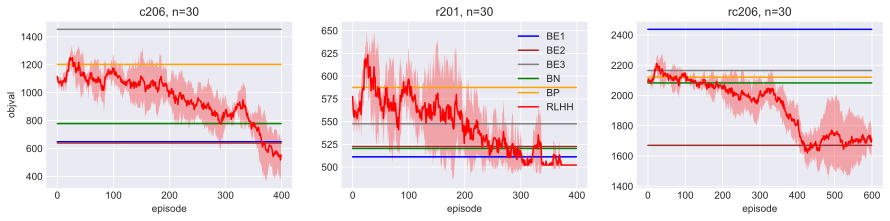

In [ ]:
baseline_c = [648.1349, 639.1518, 1453.2606, 778.2824, 1201.9879]
baseline_r = [511.2593, 522.5584, 547.5779, 520.4402, 587.5677]
baseline_rc = [2437.5518, 1670.5736, 2165.1814, 2083.0782, 2120.8272]

fig, axes = plt.subplots(1, 3, figsize=(15, 3))
axes[0] = draw_train(axes[0], generate_data_c(400), baseline_c, title="c206, n=30", ylabel=True, legend=False)
axes[1] = draw_train(axes[1], generate_data_r(400), baseline_r, title="r201, n=30", ylabel=False, legend=True)
axes[2] = draw_train(axes[2], generate_data_rc(600), baseline_rc, title="rc206, n=30", ylabel=False, legend=False)
plt.savefig("C:/Users/cccyd/Desktop/train_curve.png", dpi=400, bbox_inches="tight")

### 迭代过程

In [ ]:
def load_rlhh(rlhh_file):
    f = open(rlhh_file, 'r')
    lines = f.readlines()
    lines = [line.split("\n")[0] for line in lines]
    array = [[info.split(":")[1] for info in line.split(', ')] for line in lines]
    columns = [info.split(":")[0] for info in lines[0].split(', ')]
    df = pd.DataFrame(data=array, columns=columns)
    df[["reward", "objval", "time"]] = df[["reward", "objval", "time"]].astype('float64')
    return df   # [:-int(len(df)/2.5)]
    
def load_baseline(base_file):
    f = open(base_file, 'r')
    line = f.readline()   # 每次读取一行内容
    data = {}
    while line:
        if "heuristic" in line:
            method = line.split(":  ")[-1][:-1]
            objval = []
            time = []
        elif "iteration" in line:
            info = line[:-1].split(", ")
            objval.append(float(info[1]))
            time.append(float(info[2]))
        else:
            data[method] = {"objval": objval, "time": time}
        line = f.readline()
    return data

In [ ]:
def draw_iteration_process(ax, instance):
    base_file = f"../result/detail/log_{instance}.txt"
    rlhh_file = f"../result/detail/RLHH_log_{instance}.txt"
    data = load_baseline(base_file)
    df = load_rlhh(rlhh_file)
    for i, method in enumerate(data.keys()):
        if method == 'Hyper':
            continue
        info = data[method]
        if (instance == "r201_100" and method == "BestEdges2"):
            ax.plot(df['time'], df['objval'], 'brown', label="BE2")
        else:
            ax.plot(info['time'], info['objval'], colors[i], label=methods[method])
    if (instance == "r201_100"):
        ax.plot(data["BestEdges2"]['time'], data["BestEdges2"]['objval'], 'red', label="RLHH")
    else:
        ax.plot(df['time'], df['objval'], 'red', label="RLHH")

    ax.set_xlabel("time")
    # plt.yticks([]) # 隐藏y坐标轴
    ax.axes.yaxis.set_ticklabels([]) # 隐藏y坐标轴
    ax.set_ylabel("ObjVal")
    ax.legend()

In [ ]:
prob_types = ['r2']   # ['c1', 'c2', 'r1', 'r2', 'rc1', 'rc2']
Nums = [25, 50, 75, 100]
nrows = len(prob_types)
ncols = len(Nums)
plt.rcParams['figure.figsize']=(15, 3*nrows)
fig, axes = plt.subplots(nrows, ncols)
for j, customerNum in enumerate(Nums):
    instance = f"r201_{customerNum}"
    draw_iteration_process(axes[j], instance)
    axes[j].set_title(f"r201, n={customerNum}")
plt.savefig("F:/Users/Documents/汇报/img/vrptw_iteration_process.png", dpi=400, bbox_inches="tight")

## End